In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from itertools import product

In [2]:
# Data Loading
def load_cifar10():
    transform = transforms.Compose([transforms.ToTensor()])
    cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    target_classes = [9, 1]
    mask = [label in target_classes for _, label in cifar10]
    cifar10.data = cifar10.data[mask]
    cifar10.targets = [0 if label == 9 else 1 for label in cifar10.targets if label in target_classes]
    return cifar10

# Preprocess Data
def preprocess_data(cifar10, n_components):
    flattened_images = cifar10.data.reshape(cifar10.data.shape[0], -1).astype(np.float32)
    scaler = StandardScaler()
    normalized_images = scaler.fit_transform(flattened_images)
    
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(normalized_images)
    
    # Split dataset
    train_size = int(0.7 * len(pca_data))
    val_size = int(0.15 * len(pca_data))
    test_size = len(pca_data) - train_size - val_size
    train_data, val_data, test_data = random_split(
        list(zip(pca_data, cifar10.targets)), [train_size, val_size, test_size]
    )
    return train_data, val_data, test_data, pca

In [3]:
# Define the FNN Model
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [4]:
# Perform hyperparameter tuning
def hyperparameter_tuning(cifar10, param_grid):
    best_params = None
    best_val_accuracy = 0
    results = []

    # Iterate over all combinations of hyperparameters
    for n_components, hidden_dim, lr, batch_size, epochs in product(
        param_grid['n_components'], param_grid['hidden_dim'], param_grid['lr'], param_grid['batch_size'], param_grid['epochs']
    ):
        print(f"Trial: n_components={n_components}, hidden_dim={hidden_dim}, lr={lr}, batch_size={batch_size}, epochs={epochs}")

        # Preprocess data
        train_data, val_data, _, _ = preprocess_data(cifar10, n_components=n_components)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        # Initialize model, optimizer, and loss
        model = FNN(input_dim=n_components, hidden_dim=hidden_dim, output_dim=2)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(epochs):
            model.train()
            for images, labels in train_loader:
                images = torch.as_tensor(images, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.long)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation loop
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = torch.as_tensor(images, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.long)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Save results and update best parameters
        results.append((n_components, hidden_dim, lr, batch_size, epochs, val_accuracy))
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {
                'n_components': n_components,
                'hidden_dim': hidden_dim,
                'lr': lr,
                'batch_size': batch_size,
                'epochs': epochs
            }

    print(f"Best Parameters: {best_params}")
    return best_params, results

In [5]:
# Final Training and Testing
def final_training_and_testing(cifar10, best_params):
    # Preprocess data with best n_components
    train_data, val_data, test_data, pca = preprocess_data(cifar10, n_components=best_params['n_components'])
    train_val_data = train_data + val_data

    # DataLoaders
    train_loader = DataLoader(train_val_data, batch_size=best_params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_data, batch_size=best_params['batch_size'], shuffle=False)

    # Initialize model, optimizer, and loss
    model = FNN(input_dim=best_params['n_components'], hidden_dim=best_params['hidden_dim'], output_dim=2)
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
    criterion = nn.CrossEntropyLoss()

    training_losses = []
    test_losses = []
    training_accuracies = []
    test_accuracies = []
    epochs = best_params['epochs']
    all_test_labels = []
    all_test_probs = []
    all_test_preds = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = torch.as_tensor(images, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Training Accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        training_losses.append(epoch_loss / len(train_loader))
        training_accuracies.append(train_accuracy)

        # Test loop
        model.eval()
        epoch_test_loss = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = torch.as_tensor(images, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.long)
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_test_loss += loss.item()

                probs = nn.Softmax(dim=1)(outputs)[:, 1]
                _, predicted = torch.max(outputs, 1)
                all_test_probs.extend(probs.numpy())
                all_test_labels.extend(labels.numpy())
                all_test_preds.extend(predicted.numpy())
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(epoch_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Calculate Final Metrics
    accuracy = correct_test / total_test
    fpr, tpr, _ = roc_curve(all_test_labels, all_test_probs)
    auroc = roc_auc_score(all_test_labels, all_test_probs)
    conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

    # Cumulative Explained Variance Plot
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance for Best n_components')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Training and Test Accuracy vs Epochs
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), training_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy over Epochs')
    plt.legend()
    plt.show()

    # Train and Test Accuracy vs n_components
    train_accuracies_nc = []
    test_accuracies_nc = []

    for n_components in param_grid['n_components']:
        train_data_nc, val_data_nc, test_data_nc, _ = preprocess_data(cifar10, n_components=n_components)
        train_val_data_nc = train_data_nc + val_data_nc

        train_loader_nc = DataLoader(train_val_data_nc, batch_size=best_params['batch_size'], shuffle=True)
        test_loader_nc = DataLoader(test_data_nc, batch_size=best_params['batch_size'], shuffle=False)

        # Retrain with current n_components
        model_nc = FNN(input_dim=n_components, hidden_dim=best_params['hidden_dim'], output_dim=2)
        optimizer_nc = optim.Adam(model_nc.parameters(), lr=best_params['lr'])
        model_nc.train()

        for epoch in range(best_params['epochs']):
            for images, labels in train_loader_nc:
                images = torch.as_tensor(images, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.long)
                optimizer_nc.zero_grad()
                outputs = model_nc(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer_nc.step()

        # Evaluate training accuracy
        correct_train_nc = 0
        total_train_nc = 0
        with torch.no_grad():
            for images, labels in train_loader_nc:
                images = torch.as_tensor(images, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.long)
                outputs = model_nc(images)
                _, predicted = torch.max(outputs, 1)
                total_train_nc += labels.size(0)
                correct_train_nc += (predicted == labels).sum().item()
        train_accuracies_nc.append(correct_train_nc / total_train_nc)

        # Evaluate test accuracy
        correct_test_nc = 0
        total_test_nc = 0
        with torch.no_grad():
            for images, labels in test_loader_nc:
                images = torch.as_tensor(images, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.long)
                outputs = model_nc(images)
                _, predicted = torch.max(outputs, 1)
                total_test_nc += labels.size(0)
                correct_test_nc += (predicted == labels).sum().item()
        test_accuracies_nc.append(correct_test_nc / total_test_nc)

    plt.figure(figsize=(8, 6))
    plt.plot(param_grid['n_components'], train_accuracies_nc, label='Training Accuracy', marker='o')
    plt.plot(param_grid['n_components'], test_accuracies_nc, label='Test Accuracy', marker='x')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy vs Number of PCA Components')
    plt.legend()
    plt.show()

    print(f"Final Test Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"Per-Class Accuracy: {dict(enumerate(per_class_accuracy))}")

    return accuracy, auroc, per_class_accuracy

Files already downloaded and verified


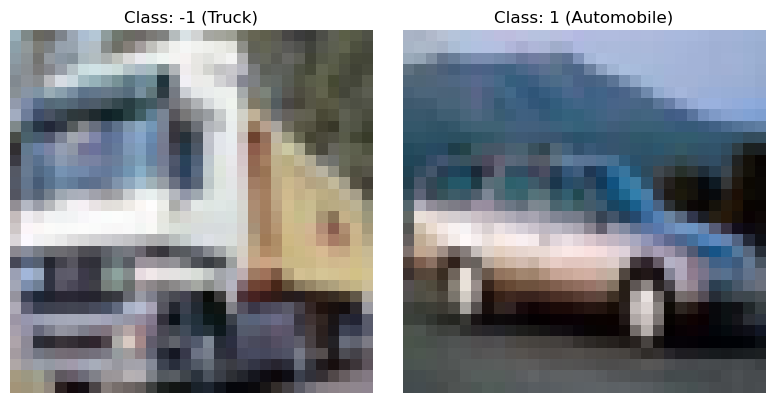

Trial: n_components=50, hidden_dim=64, lr=0.0001, batch_size=16, epochs=10
Validation Accuracy: 0.7253
Trial: n_components=50, hidden_dim=64, lr=0.0001, batch_size=16, epochs=20
Validation Accuracy: 0.7380
Trial: n_components=50, hidden_dim=64, lr=0.0001, batch_size=16, epochs=50
Validation Accuracy: 0.7620
Trial: n_components=50, hidden_dim=64, lr=0.0001, batch_size=32, epochs=10
Validation Accuracy: 0.7020
Trial: n_components=50, hidden_dim=64, lr=0.0001, batch_size=32, epochs=20
Validation Accuracy: 0.7360
Trial: n_components=50, hidden_dim=64, lr=0.0001, batch_size=32, epochs=50
Validation Accuracy: 0.7613
Trial: n_components=50, hidden_dim=64, lr=0.0001, batch_size=64, epochs=10
Validation Accuracy: 0.6907
Trial: n_components=50, hidden_dim=64, lr=0.0001, batch_size=64, epochs=20
Validation Accuracy: 0.7080
Trial: n_components=50, hidden_dim=64, lr=0.0001, batch_size=64, epochs=50
Validation Accuracy: 0.7460
Trial: n_components=50, hidden_dim=64, lr=0.001, batch_size=16, epochs=10

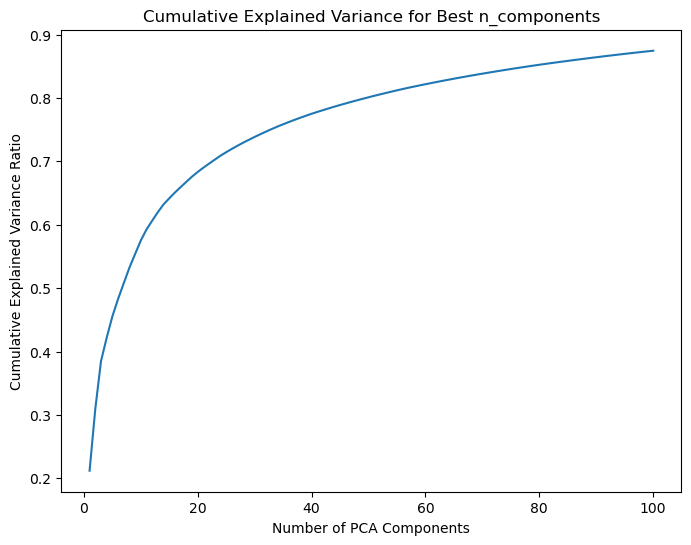

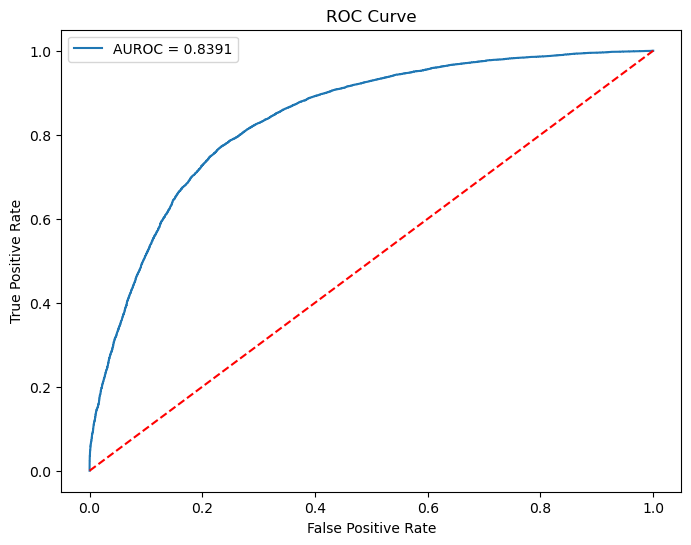

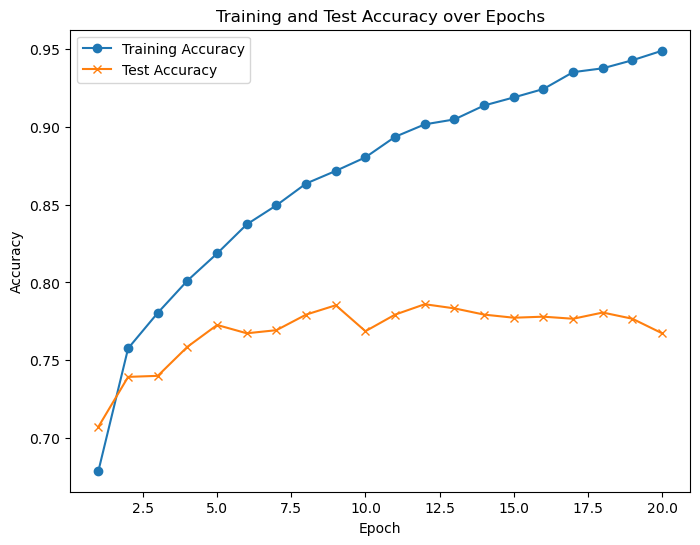

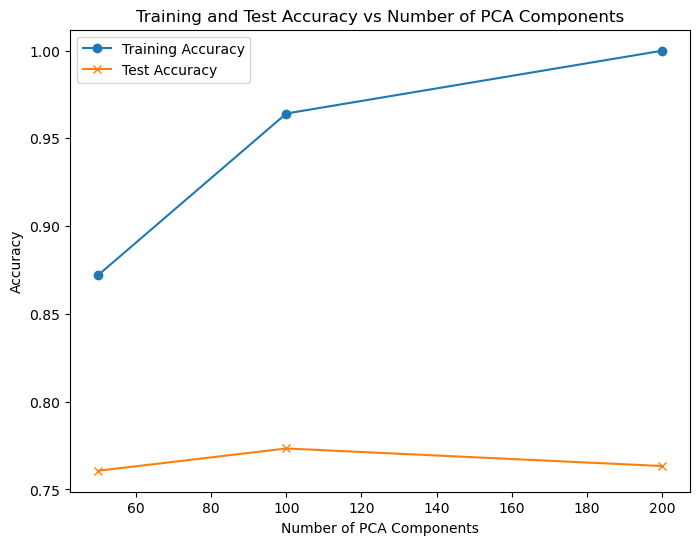

Final Test Accuracy: 0.7673
AUROC: 0.8391
Per-Class Accuracy: {0: 0.7537878787878788, 1: 0.7825581395348837}


(0.7673333333333333, 0.8391359952591454, array([0.75378788, 0.78255814]))

In [6]:
cifar10 = load_cifar10()

truck_idx = cifar10.targets.index(0)
automobile_idx = cifar10.targets.index(1)

# Display sample images for Truck (-1) and Automobile (1)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(cifar10.data[truck_idx])
axes[0].set_title("Class: -1 (Truck)")
axes[0].axis('off')

axes[1].imshow(cifar10.data[automobile_idx])
axes[1].set_title("Class: 1 (Automobile)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

param_grid = {
    'n_components': [50, 100, 200],
    'hidden_dim': [64, 128, 256],
    'lr': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 50]
}

best_params, _ = hyperparameter_tuning(cifar10, param_grid)
final_training_and_testing(cifar10, best_params=best_params)

In [8]:
per_class_accuracy = {0: 0.7537878787878788, 1: 0.7825581395348837}
index_to_class_label = {0: -1, 1: 1}
mapped_per_class_accuracy = {index_to_class_label[k]: v for k, v in per_class_accuracy.items()}
print("Mapped Per-Class Accuracy:", mapped_per_class_accuracy)

Mapped Per-Class Accuracy: {-1: 0.7537878787878788, 1: 0.7825581395348837}
